#Speech Processing Lab - Week 10

Name: S U Swakath 

Roll number: 180020036

Google Colab Link : https://colab.research.google.com/drive/1PqBT35TTD3TtnBE0fZ3TdUlQpNJvEAaK?usp=sharing

**Aim**

* Develop a method for the estimation of pitch by the autocorrelation of speech signal.
* Develop a cepstrum pitch estimation method.
* Develop a simple inverse filtering technique(SIFT) pitch estimation method.
Comparison of all these three methods.


**Theory**

Speech signal can be classified into voiced, unvoiced and silence regions. The near periodic vibration of vocal folds is excitation for the production of voiced speech, the random noise like excitation for production of unvoiced speech and  no excitation during silence region. Majority of speech regions are voiced in nature that includevowels, semivowels and other voiced components. The voiced regions looks like a near periodic signal in the time domain representation. In a short term analysis, we may treat the voiced speech segments to be periodic for all practical analysis and processing. The periodicity associated with such segmentsis defined is 'pitch period To' in the time domain and 'Pitch frequency or Fundamental Frequency Fo' in the frequency domain. Unless specified, the term 'pitch' refers to the fundamental frequency ' Fo'. Pitch is an important attribute of voiced speech. It contains speaker-specific information. It is also needed for speech coding task. Thus estimation of pitch is one of the important issue in speech processing.


There are a large set of methods that have been developed in the speech processing area for the estimation of pitch. Among them the three mostly used methods include, autocorrelation of speech, cepstrum pitch determination and SIFT pitch estimation. One success of these methods is due to the involvment of simple steps for the estimation of pitch. Even though autocorrelation method is of theoritical interest, it produce a frame work for SIFT methods.

In [2]:
# Mounting Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Changing directory
%cd /content/gdrive/MyDrive/Sem6/Speech Lab/Week10
!ls

/content/gdrive/MyDrive/Sem6/Speech Lab/Week10
Lab10.ipynb  week10audio.wav


In [6]:
# Importing Libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy import signal
import scipy.fft
from scipy.io import wavfile
import librosa
import librosa.display
import soundfile as sf

#Functions 

# Magnitude spuctrum plot function
def magnitudeSpectrum(sound):
    
  # Computing the FFT of the sound
  sound_len = sound.shape[0]
  sound_fft = fft(sound)/sound_len

  # Computing the frequency array
  freqs = fftfreq(sound_len, 1/fs)
  
  #freqs = freqs[0:sound_len//2]
  #fft_db = 2*np.log10(np.abs(sound_fft[0:sound_len//2]))
  fft_db = np.log10(np.abs(sound_fft))
  return freqs,fft_db

def cepstrum(sound):
  #Computing the Log Magnitude Spectrum
  _,cep_fft_db = magnitudeSpectrum(sound)
  cepCoff = scipy.fft.ifft(cep_fft_db)
  return cepCoff

def autocorr(sound):
  len = sound.shape[0]
  shift = np.arange(0, len, 1)
  autocorr = np.zeros((shift.shape[0],))

  for curr_shift in shift:
    autocorr[curr_shift] = np.dot(sound[0:len-curr_shift].T,sound[curr_shift:])
  autocorr = autocorr/autocorr[0]
  return autocorr

# Function to estimate the LPCs using autocorrelation method
   
def invMat(sound,p):
  acf = autocorr(sound)
  covMat = np.zeros([p,p])
  for i in range(p):
    for j in range(p):
      covMat[i,j] = acf[np.abs(i-j)]
  c = np.zeros([p,1])
  for i in range(p):
    c[i,0] = acf[i+1]
  
  coeff = np.matmul(np.linalg.inv(covMat),c)
  coeff = coeff.T
  coeff = coeff.reshape(p)
  return coeff

# Problem A
Pitch estimation by autocorrelation method:
* Divide the given speech signal into 30-40ms blocks of speech frames. Find and plot the auto-correlation sequence of a voiced frame and an unvoiced frame. 
* Estimate the pitch frequency using this computed auto-correlation for the above  voiced frame and an unvoiced frame. You may set a threshold for a significant peak, and assign zero to pitch frequency if there is no significant peak.


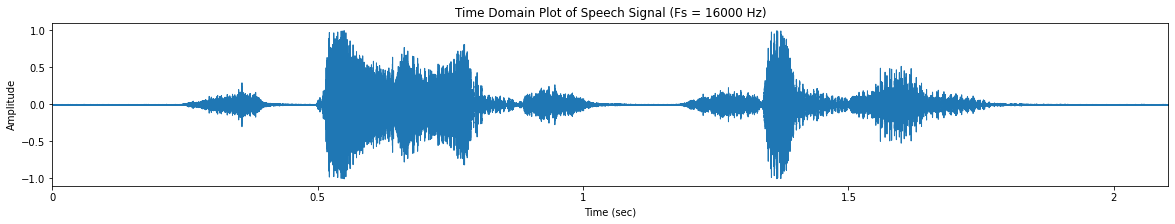

In [7]:
# Loading the audio into colab. Fs = 16kHz
audio, fs = librosa.load("week10audio.wav", sr = 16000)

# Plotting time domain plot of the audio
plt.figure(figsize=(20,3))
librosa.display.waveplot(audio, sr=fs);
plt.title("Time Domain Plot of Speech Signal (Fs = " +str(fs)+" Hz)")
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()

In [8]:
# Function to compute Pitch using ACF method
def acfPitchCalculator(sound,fs):
  time = np.arange(0, len(sound)/fs, 1/fs)
  acf = autocorr(sound)
  peaks = signal.find_peaks(acf,prominence=1)
  args = peaks[0]
  args = np.array(args)
  acfPitch = 0
  if len(args)>1:
    diff = time[args[1]] - time[args[0]]
    acfPitch = 1/diff
  return acfPitch

# Extracting different categories of sound in the speech
# The time stamp for each sound component was extracted from wavesurfer and they
# are as follows:
# /s/  - 0.236 s to 0.387 s
# /ee/ - 0.591 s to 0.756 s
# /ch/ - 0.883 s to 0.992 s
# /n/  - 1.407 s to 1.503 s
# sil  - 1.101 s to 1.165 s

s = audio[int(0.236*fs):int(0.387*fs)]
ee = audio[int(0.591*fs):int(0.756*fs)]
ch = audio[int(0.883*fs):int(0.992*fs)]
n = audio[int(1.407*fs):int(1.503*fs)]
sil = audio[int(1.101*fs):int(1.165*fs)]  

#Choosing one voiced sound (ee) and one unvoiced sound (s) and taking 30ms of the sound
frameSize = 0.030 * fs
acfTime = np.arange(0, frameSize/fs, 1/fs)
choose = [ee,s]
soundName = ['/ee/','/s/']
soundType = ['Voiced','Unvoiced']
acfSounds = []
midFrame = frameSize/2
for curSound in choose:
  N = len(ee) / 2
  frame = curSound[int (N-midFrame): int (N+midFrame)]
  acfSounds.append(frame)

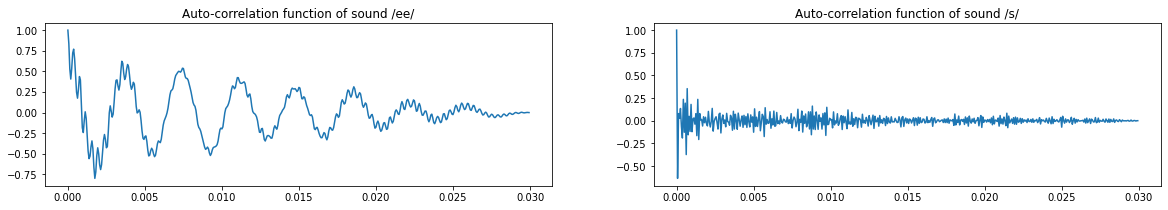

In [9]:
i = 0
acf = []
plt.figure(figsize=(20,3))
for curSound in acfSounds:
  curAcf=autocorr(curSound)
  curAcf = curAcf/curAcf[0]
  acf.append(curAcf)
  plt.subplot(1,2,i+1)
  plt.plot(acfTime,curAcf)
  plt.title("Auto-correlation function of sound "+soundName[i])
  i=i+1
plt.show()

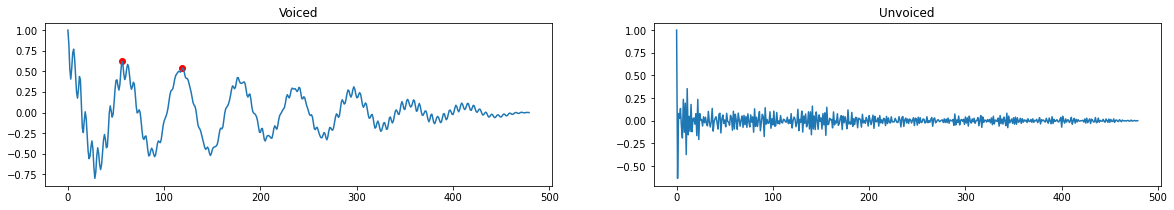

Pitch computed through ACF method (in Hz): 
Voiced (/ee/): 253.97 Hz
Unvoiced (/s/): 0.00 Hz

--------------------------------
Results through Function: 
253.96825396825398
0


In [10]:
acfPitch = []
i = 0
plt.figure(figsize=(20,3))
for curAcf in acf:
  peaks = signal.find_peaks(curAcf,prominence=1)
  args = peaks[0]
  args = np.array(args)
  curPitch = 0
  if len(args)>1:
    diff = acfTime[args[1]] - acfTime[args[0]]
    curPitch = 1/diff
  acfPitch.append(curPitch)
  plt.subplot(1,2,i+1)
  plt.plot(curAcf)
  plt.title(soundType[i])
  plt.scatter(args,curAcf[args],marker= "o",color='red')
  i = i+1
plt.show()  
print("Pitch computed through ACF method (in Hz): ")
for i in range(len(acfSounds)):
  print(soundType[i] + " ("+ soundName[i]+"): " + "{:.2f}".format(acfPitch[i])+" Hz")

print("\n--------------------------------")
print("Results through Function: ")
for curSound in acfSounds:
  a = acfPitchCalculator(curSound,fs)
  print(a)

# Problem B
Cepstrum based pitch estimation:
* Divide the speech into  short segments of 15-20ms frame size. Compute the cepstrum of the speech segment in the quefrency domain for each of these frames  and plot for one voiced frame.
* Estimate the pitch period by the high time liftering of the cepstrum of the voiced speech. 
* Estimate the pitch period by the high time liftering of the cepstrum of the unvoiced speech.


In [11]:
#Function to calculate Pitch using Cepstrum method
def cepPitchCalculator(sound,lc=15):
  length = len(sound)
  freqs,_=magnitudeSpectrum(sound)
  freqs = freqs[0:length//2]
  # Computing the hamming window 
  window = np.hamming(length)
  # Computing windowed sound signal
  winSound = np.multiply(sound,window)
  # Computing the cepstrum of the sound frame
  cep = cepstrum(winSound)
  cepLen = len(cep)
  # Performing high time liftering
  highTime = np.zeros(cepLen)
  highTime[lc:cepLen-lc] = 1
  highLif = np.multiply(highTime,cep)
  # Computing the excitation signal
  exc= fft(highLif)
  exc = exc[0:length//2]
  # Computing the pitch of the signal
  cepPitch = freqs[np.argmax(exc)]
  return cepPitch

#Choosing one voiced sound (ee) and one unvoiced sound (s) and taking 20ms of the sound
frameSize = 0.020 * fs
cepTime = np.arange(0, frameSize/fs, 1/fs)
choose = [ee,s]
cepSounds = []
midFrame = frameSize/2
for curSound in choose:
  N = len(ee) / 2
  frame = curSound[int (N-midFrame): int (N+midFrame)]
  cepSounds.append(frame)

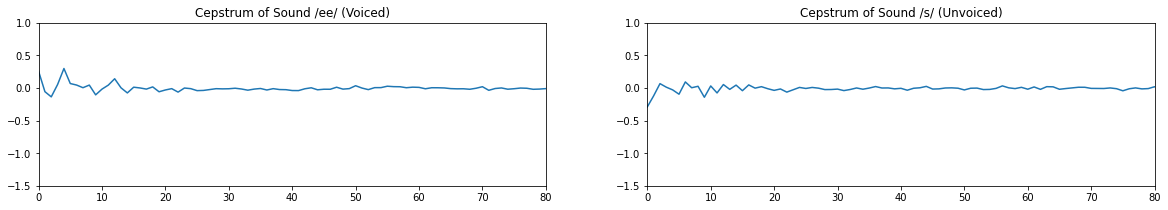

In [12]:
# Plotting Cepstrum of the audio
plt.figure(figsize=(20,3))
i = 1
window = np.hamming(frameSize)
soundCepstrums = []
for curSound in cepSounds:
  curCep = cepstrum(np.multiply(curSound,window))
  soundCepstrums.append(curCep)
  plt.subplot(1,2,i)
  plt.plot(curCep[1:].real)
  plt.title("Cepstrum of Sound " + soundName[i-1] +" (" + soundType[i-1] + ")" )
  plt.ylim([-1.5,1])
  plt.xlim([0,80])
  i = i+1
plt.show()

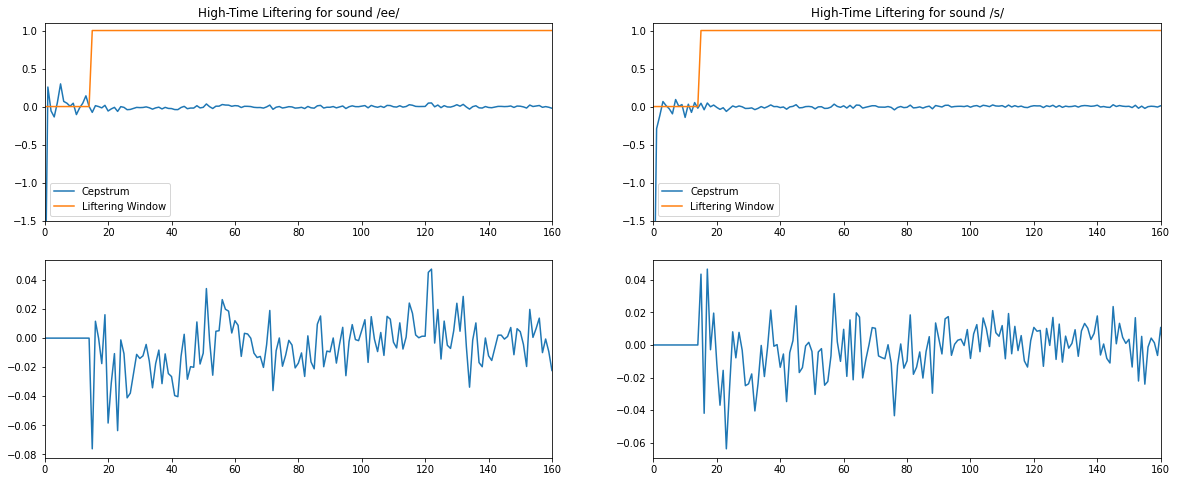

In [13]:
highLifter = []
lc = 15
plt.figure(figsize=(20,8))
i = 1
for curCep in soundCepstrums:
  curLen = len (curCep)
  highTime = np.zeros(curLen)
  highTime[lc:curLen-lc] = 1
  curLif = np.multiply(highTime,curCep)
  highLifter.append(curLif)
  plt.subplot(2,2,i)
  plt.plot(curCep.real)
  plt.plot(highTime)
  plt.ylim([-1.5,1.1])
  plt.xlim([0,160])
  plt.title("High-Time Liftering for sound " + soundName[i-1])
  plt.legend(['Cepstrum','Liftering Window'])
  
  plt.subplot(2,2,i+2)
  plt.plot(curLif.real)
  plt.xlim([0,160])
  i = i+1
plt.show()

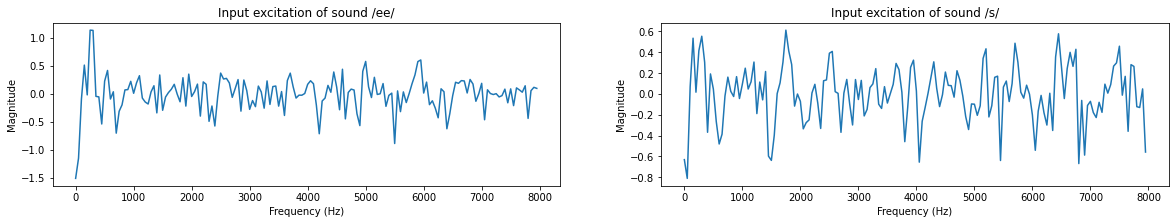

Pitch computed through Cepstrum method (in Hz): 
Voiced (/ee/): 250.00 Hz
Unvoiced (/s/): 1750.00 Hz

----------------------
Pitch computed using Function
250.0
1750.0


In [14]:
curSound = cepSounds[0]
freqs,freq_db = magnitudeSpectrum(curSound)
curLen = curSound.shape[0]
cepSoundFreq = freqs[0:curLen//2]

soundExcitation = []
cepPitch = []
plt.figure(figsize=(20,3))
for i in range(len(soundCepstrums)):
  curHigh = highLifter[i]
  curLen = curHigh.shape[0]
  excitation = fft(curHigh)
  excitation = excitation[0:curLen//2]
  soundExcitation.append(excitation.real)
  curPitch = cepSoundFreq[np.argmax(excitation)]
  cepPitch.append(curPitch)
  plt.subplot(1,2,i+1)
  plt.plot(cepSoundFreq,excitation.real)
  plt.title("Input excitation of sound " +soundName[i])
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Magnitude")
plt.show()

print("Pitch computed through Cepstrum method (in Hz): ")
for i in range(len(acfSounds)):
  print(soundType[i] + " ("+ soundName[i]+"): " + "{:.2f}".format(cepPitch[i])+" Hz")

print("\n----------------------\nPitch computed using Function")

for curSound in cepSounds:
  print(cepPitchCalculator(curSound))


# Problem C
Pitch estimation by Simple Inverse Filtering Technique (SIFT):
* Take a 30 ms voiced speech segment and compute the Linear Prediction (LP) residual by LP analysis.  Perform autocorrelation on the LP residual. Estimate of pitch period from the autocorrelation sequence of the LP residual. 
* Perform the same for the unvoiced speech segment also.


In [15]:
# Function to compute pitch using LPC method
def lpcPitchCalculator(sound,fs,p=12):
  length = len(sound)
  time = np.arange(0, length/fs, 1/fs)
  window = np.hamming(length)
  winSound = np.multiply(sound,window)
  lpc = invMat(winSound,p)
  A = np.insert(-1*lpc, 0, 1)
  residual = np.convolve(winSound,A)
  residual = residual[0:-len(A)+1] 
  acf = autocorr(residual)
  thresh = acf[0]*0.15
  peaks = signal.find_peaks(acf,height=thresh,distance = 20)
  args = peaks[0]
  args = np.array(args)
  pitch = 0
  if len(args) >1:
    diff = time[args[1]] - time[args[0]]
    pitch = (1/diff)
  return pitch


#Choosing one voiced sound (ee) and one unvoiced sound (s) and taking 30ms of the sound
frameSize = 0.030 * fs
lpcTime = np.arange(0, frameSize/fs, 1/fs)
choose = [ee,s]
lpcSounds = []
midFrame = frameSize/2
for curSound in choose:
  N = len(ee) / 2
  frame = curSound[int (N-midFrame): int (N+midFrame)]
  lpcSounds.append(frame)


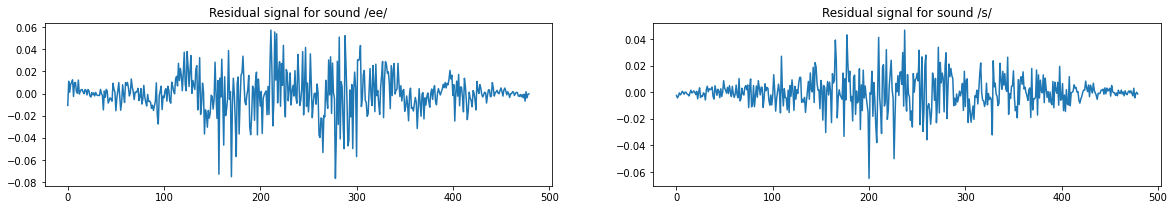

In [16]:
lpcCoeff = []
residualSignals = []
window = np.hamming(frameSize)
p  = 12
i = 0
plt.figure(figsize=(20,3))
for curSound in lpcSounds:
  winSound = np.multiply(curSound,window)
  curCoeff = invMat(winSound, p)
  curA = np.insert(-1*curCoeff, 0, 1)
  lpcCoeff.append(curA)
  curResidual = np.convolve(winSound,curA)
  curResidual = curResidual[0:-len(curA)+1]
  residualSignals.append(curResidual)
  plt.subplot(1,2,i+1)
  plt.title("Residual signal for sound "+soundName[i])
  plt.plot(curResidual)
  i = i+1
plt.show()

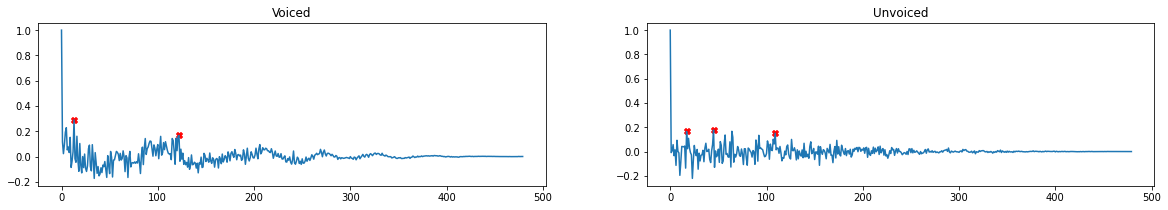

Pitch computed through LPC method (in Hz): 
Voiced (/ee/): 146.79 Hz
Unvoiced (/s/): 571.43 Hz

----------------------
Pitch computed using Function
146.78899082568807
571.4285714285714


In [17]:
i = 0
lpcPitch = []
plt.figure(figsize=(20,3))
for curResidual in residualSignals:
  curAuto = autocorr(curResidual)
  #curAuto[0] = curAuto[1]
  curAuto = curAuto/curAuto[0]
  thresh = curAuto[0]*0.15
  peaks = signal.find_peaks(curAuto,height=thresh,distance = 20)
  args = peaks[0]
  args = np.array(args)
  plt.subplot(1,2,i+1)
  plt.title(soundType[i])
  plt.plot(curAuto)
  plt.scatter(args,curAuto[args],marker='X',color = 'red')
  curPitch = 0
  if len(args) >1:
    diff = lpcTime[args[1]] - lpcTime[args[0]]
    curPitch = (1/diff)
  i = i+1
  lpcPitch.append(curPitch)
plt.show()
print("Pitch computed through LPC method (in Hz): ")
for i in range(len(lpcSounds)):
  print(soundType[i] + " ("+ soundName[i]+"): " + "{:.2f}".format(lpcPitch[i])+" Hz")

print("\n----------------------\nPitch computed using Function")

for curSound in lpcSounds:
  print(lpcPitchCalculator(curSound,fs))


# Problem D
Comparison of pitch estimation methods:
* Plot the entire input speech signal and it’s pitch contours  estimated using autocorrelation,  cepstrum and SIFT based pitch estimation methods.


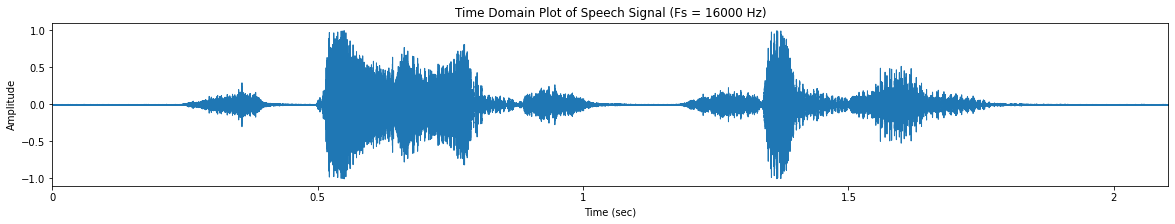

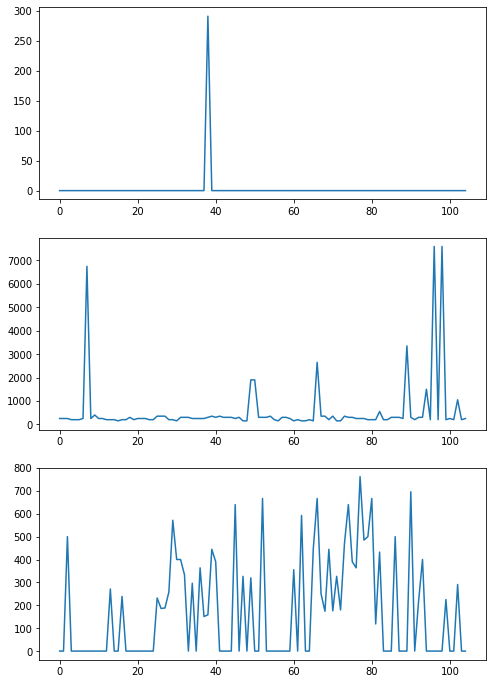

In [22]:
# Plotting time domain plot of the audio
plt.figure(figsize=(20,3))
librosa.display.waveplot(audio, sr=fs);
plt.title("Time Domain Plot of Speech Signal (Fs = " +str(fs)+" Hz)")
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()

frameSize = 0.020 * fs
number = int(np.floor(audio.shape[0]/(frameSize)))
#axis 0 - acf
#axis 1 - cepstrum
#axis 2 - LPC
acfPitch = np.zeros((number,)) 
cepPitch = np.zeros((number,))
lpcPitch = np.zeros((number,))
for i in range(number):
  frame = audio[int(i*frameSize) : int((i+1)*frameSize)]
  acfPitch[i] = acfPitchCalculator(frame,fs)
  cepPitch[i] = cepPitchCalculator(frame)
  lpcPitch[i] = lpcPitchCalculator(frame,fs)

plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.plot(acfPitch)
plt.subplot(3,1,2)
plt.plot(cepPitch)
plt.subplot(3,1,3)
plt.plot(lpcPitch)


In [ ]:
print(allAcfPitch)